# Dataset Proposal v.1.0

In [87]:
import time
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from datetime import datetime as dt
from itertools import count
%matplotlib inline
# to rotate 3D plot interactively
%matplotlib notebook
# Test if coordinates.csv is correct

def get_path():
    Path = 'Dataset_Proposal/coordinates_yz.csv'
    return Path

def get_coords():
    Path = get_path()
    csv_df = pd.read_csv(Path,header=None) # ,header=None
    csv_np = csv_df.to_numpy()
    print(f'original array from coordinates.csv has shape: {csv_np.shape}')
    
    cogs = csv_np[:,0:3]
    x_coord = np.expand_dims(csv_np[:,3::3], axis=1)
    y_coord = np.expand_dims(csv_np[:,4::3], axis=1)
    z_coord = np.expand_dims(csv_np[:,5::3], axis=1)
    coords = np.concatenate((x_coord,y_coord,z_coord), axis=1)
    print(f'coords shape: {coords.shape}')
    print(f'x_coord shape: {coords[:,0,:].shape}')
    return coords

coords = get_coords()

original array from coordinates.csv has shape: (18000, 81)
coords shape: (18000, 3, 26)
x_coord shape: (18000, 26)


### 1. Input original data from coordinates.csv and test if data is correct
<font size=2>
  
The **coordinates.csv** is generated from **MCS_chart.ipynb** after selecting recognizable data. Note that the original unit from Unknown.csv was **mm**, but the extracted data into **coordinates.csv** has already been transferred into **m**.
    
Here are indices and corresponding joints in each coordinate-array (i.e.x_coord,y_coord,z_coord), **after** eliminating columns of **center of gravity**:
    
    0:LWrist 1:LElbow 2:LShoulder
    3:RWrist 4:RElbow 5:RShoulder
    6:LToe 7:LAnkle 8:LKnee 9:LHip
    10:RToe 11:RAnkle 12:RKnee 13:RHip
    14:LClavicle 15:LHandEnd 16:LToesEnd
    17:RClavicle 18:RHandEnd 19:RToesEnd
    20:spine1 21:spine2 22:spine3 23:spine4 24:spine5 25:head 
    
</font>

#### Plot to check dataset

In [89]:
#######################################
###### connect joints with links ######
#######################################

def get_links_dict():
    links_dict = {'left arm': [15,0,1,2,14,24],
                  'right arm': [18,3,4,5,17,24],
                  'left leg': [16,6,7,8,9,20],
                  'right leg': [19,10,11,12,13,20],
                  'spine': [20,21,22,23,24,25]
                 }
    return links_dict

def connect(frame,ax,joints):
    idx_lst = [[],[],[]]
    for i in joints:
        idx_lst[0].append(frame[0,i])
        idx_lst[1].append(frame[1,i])
        idx_lst[2].append(frame[2,i])
        ax.plot(idx_lst[0], idx_lst[1], idx_lst[2], color='red')

def connect_with_lines(frame,ax,links_dict):
    for link_name,joints in links_dict.items():
        connect(frame,ax,joints)

##################
###### plot ######
##################

def calc_axis_limit(coords):
    x_high, x_low = int(np.ceil(coords[:,0,:].max()*1000/200.0))*200, int(np.floor(coords[:,0,:].min()*1000/200.0))*200
    y_high, y_low = int(np.ceil(coords[:,1,:].max()*1000/200.0))*200, int(np.floor(coords[:,1,:].min()*1000/200.0))*200
    z_high, z_low = int(np.ceil(coords[:,2,:].max()*1000/200.0))*200, int(np.floor(coords[:,2,:].min()*1000/200.0))*200
    return [[x_high, x_low],[y_high, y_low],[z_high, z_low]]

def prepare_ax(coords,ax,limits):
    # axis label
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    # axis limit
    x_high, x_low = limits[0][0],limits[0][1]
    y_high, y_low = limits[1][0],limits[1][1]
    z_high, z_low = limits[2][0],limits[2][1]
    ax.axes.set_xlim3d(left=x_low/1000.0, right=x_high/1000.0) 
    ax.axes.set_ylim3d(bottom=y_low/1000.0, top=y_high/1000.0)
    ax.axes.set_zlim3d(bottom=z_low/1000.0, top=z_high/1000.0)
    # axis scale
    ax.set_xticks(list(i/1000.0 for i in range(x_low,x_high,200)))
    ax.set_yticks(list(i/1000.0 for i in range(y_low,y_high,200)))
    ax.set_zticks(list(i/1000.0 for i in range(z_low,z_high,200)))
    # axis aspect ratio
    ax.set_box_aspect(aspect = (x_high-x_low,y_high-y_low,z_high-z_low))
    
def plot_func(frame_id,ax,coords,links_dict,limits,title):
    # plot links in 3D 
    ax.cla()
    current_frame = coords[frame_id]
    prepare_ax(coords,ax,limits)
    ax.set_title(title)
    ax.scatter3D(current_frame[0], current_frame[1], current_frame[2], c='steelblue', marker='<')
    connect_with_lines(current_frame,ax,links_dict)

original array from coordinates.csv has shape: (18000, 81)
coords shape: (18000, 3, 26)
x_coord shape: (18000, 26)


<IPython.core.display.Javascript object>


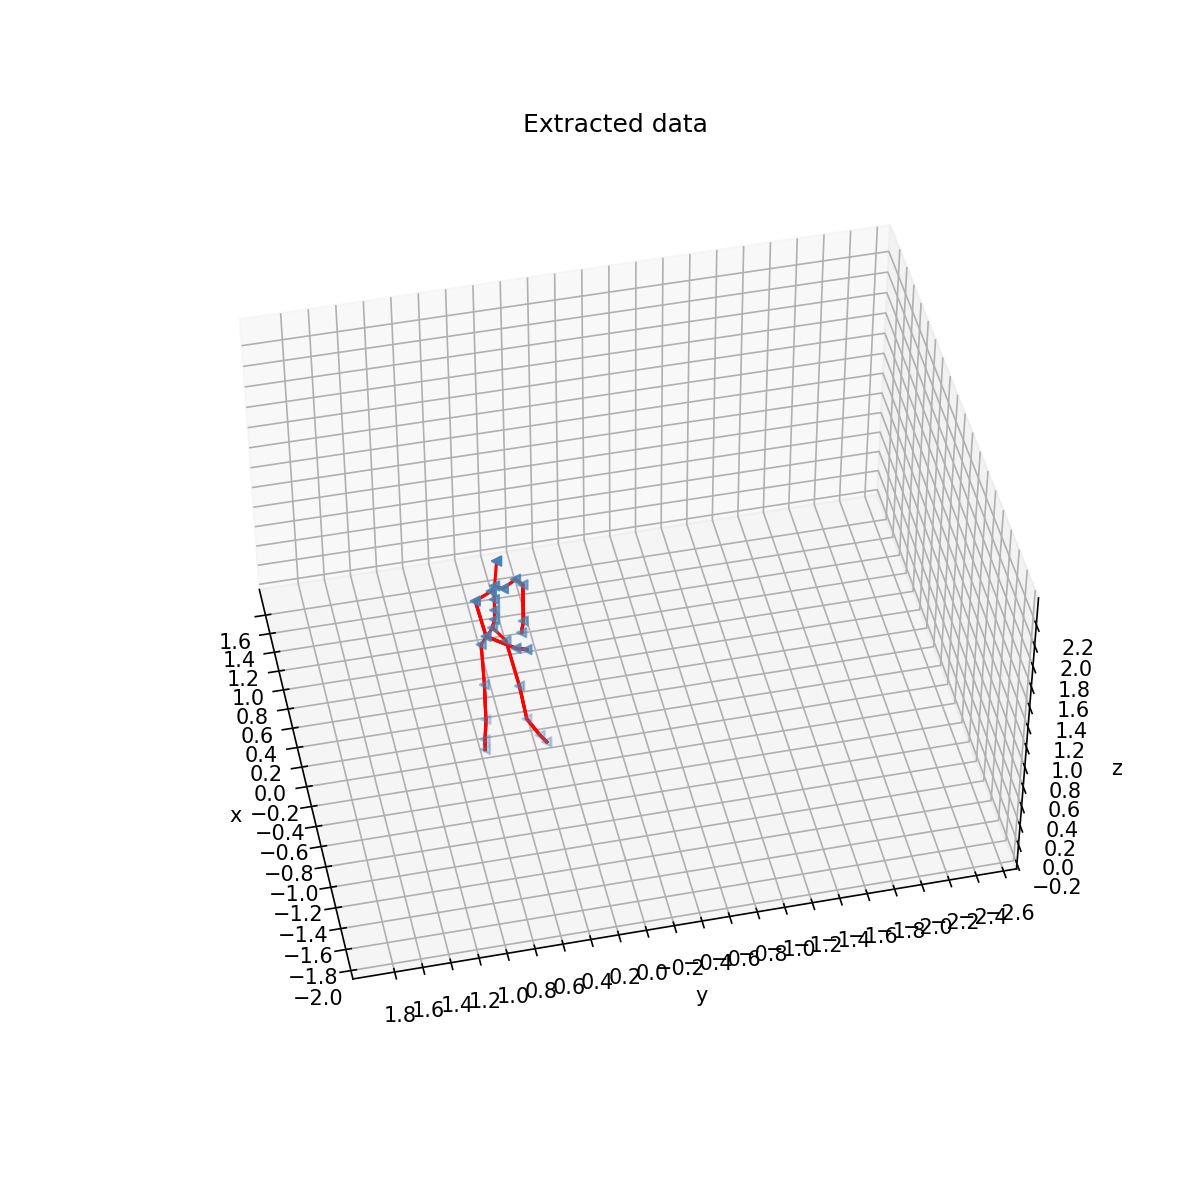

In [90]:
coords = get_coords()
links_dict = get_links_dict()
N_frames = 600
limits1 = calc_axis_limit(coords) # (x_high, x_low), (y_high, y_low), (z_high, z_low)
title1 = 'Extracted data'

fig = plt.figure(figsize=(8,8))
fig.tight_layout()
ax1 = fig.add_subplot(projection='3d')
ax1.view_init(30, 150)

ani = animation.FuncAnimation(fig,plot_func,frames=N_frames,fargs=(ax1,coords,links_dict,limits1,title1),interval=17)
plt.show()

### 2.1 Calculation of all distances
<font size=2>
    
Calculate distances between every 2 joints and save in a 2D array. E.g. there are 26 joints, then the distance-array has shape [26,26], each element [i,j] represents the distance between **joint i** and **joint j**.
    
</font>

In [103]:
def calc_distances_timeline():
    # e,g, all_distances[3,1,4] means distance between LElbow and RElbow in 3rd frame
    coords = get_coords() # coords: [frames,xyz,num_joints] = [18000,3,26]
    num_frame, num_joints = coords[:,0,:].shape
    all_distances = np.zeros((num_frame,num_joints,num_joints))
    new_coords = np.expand_dims(coords, axis=-2) # shape [18000,3,26] -> [18000,3,1,26]
    # diff = coords - transpose(coords,(0,1,3,2)):
    #   meaning: x-x.T, y-y.T, z-z.T
    #   shape: [18000,3,1,26] - [18000,3,26,1] = [18000,3,26,26]
    # sum(diff**2,axis=1):
    #   meaning: (x-x.T)**2 + (y-y.T)**2 + (z-z.T)**2
    #   shape: [18000,3,26,26] -> [18000,26,26]
    all_distances = np.sqrt(np.sum((new_coords - np.transpose(new_coords,(0,1,3,2)))**2,axis=1))
    return all_distances

all_distances = calc_distances_timeline()
print(f'all_distances shape: {all_distances.shape}')

original array from coordinates.csv has shape: (18000, 81)
coords shape: (18000, 3, 26)
x_coord shape: (18000, 26)
all_distances shape: (18000, 26, 26)


### 2.2 Examine whether distances are calculated correctly
<font size=2>
    
From 2.1, an array with shape [600,26,26] is obtained, which means there are 600 frames, in each frame there are distances between random 2 joints (from all 26 joints).
    
Below is the way to examine whether the array fulfills the expectation, i.e. whether the array truely contains information of distances.
    
</font>

In [ ]:
def get_joint_index():
    joint_index_dict = {'LWrist':0, 'LElbow':1, 'LShoulder':2,
                       'RWrist':3, 'RElbow':4, 'RShoulder':5,
                       'LToe':6, 'LAnkle':7, 'LKnee':8, 'LHip':9,
                       'RToe':10, 'RAnkle':11, 'RKnee':12, 'RHip':13,
                       'LClavicle':14, 'LHandEnd':15, 'LToesEnd':16,
                       'RClavicle':17, 'RHandEnd':18, 'RToesEnd':19,
                       'spine1':20, 'spine2':21, 'spine3':22, 'spine4':23, 'spine5':24, 'head':25
                      }
    return joint_index_dict

def examine_distance(frame, joint_1, joint_2):
    coords = get_coords() # coords: x_coord, y_coord, z_coord
    all_distances = calc_distances_timeline(coords)
    joint_index_dict = get_joint_index()
    joint_1_idx = joint_index_dict[joint_1]
    joint_2_idx = joint_index_dict[joint_2]
    dist_from_array = all_distances[frame,joint_1_idx,joint_2_idx]
    dist_calculated = np.sqrt((coords[0][frame,joint_1_idx] - coords[0][frame,joint_2_idx])**2 
                        + (coords[1][frame,joint_1_idx] - coords[1][frame,joint_2_idx])**2 
                        + (coords[2][frame,joint_1_idx] - coords[2][frame,joint_2_idx])**2
                       )
    print(f'distance indexed from distances array: {dist_from_array}')
    print(f'distance calculated from coordinates: {dist_calculated}')
    print(f'wehther the same: {dist_from_array == dist_calculated}')

frame = 359
joint_1 = 'RHandEnd'
joint_2 = 'spine3'
examine_distance(frame, joint_1, joint_2)

### 3. Calculation of angles
<font size=2>
    
Calculate angles between every 2 adjacent links and save in a np.array with shape [num_frames,num_angles]. E.g. [430,2]=2.18274673 represents the angle between link **LElbow_LShoulder** and link **LShoulder_LClavicle** is 2.18274673, in radian.
    
Indices of joints is below:
    
    0:LWrist 1:LElbow 2:LShoulder
    3:RWrist 4:RElbow 5:RShoulder
    6:LToe 7:LAnkle 8:LKnee 9:LHip
    10:RToe 11:RAnkle 12:RKnee 13:RHip
    14:LClavicle 15:LHandEnd 16:LToesEnd
    17:RClavicle 18:RHandEnd 19:RToesEnd
    20:spine1 21:spine2 22:spine3 23:spine4 24:spine5 25:head 
    
The relation and order among joints is below:
    
    index 15,0,1,2,14,24: left arm
    index 18,3,4,5,17,24: right arm
    index 16,6,7,8,9,20: left leg
    index 19,10,11,12,13,20: right leg
    index 20,21,22,23,24,25: spine

Given edges $a$,$b$,$c$ of a triangle, and the task is to calculate the angle $B$ which is opposite to edge $b$, use the following formular:
    
$$
\begin{equation}
\begin{aligned}
cos(B) &= \frac{c^{2} + a^{2} - b^{2}}{2ac} \\
B &= arccos(cos(B))
\end{aligned}
\end{equation}
$$
    
</font>

In [ ]:
def get_angle_pairs():
    angle_pairs_dict = {'LHandEnd_LWrist_LElbow':[15,0,1],
                        'LWrist_LElbow_LShoulder':[0,1,2],
                        'LElbow_LShoulder_LClavicle':[1,2,14],
                        'LShoulder_LClavicle_spine5':[2,14,24],
                        'LClavicle_spine5_spine4':[14,24,23],
                        'LClavicle_spine5_head':[14,24,25],
                        'RHandEnd_RWrist_RElbow':[18,3,4],
                        'RWrist_RElbow_RShoulder':[3,4,5],
                        'RElbow_RShoulder_RClavicle':[4,5,17],
                        'RShoulder_RClavicle_spine5':[5,17,24],
                        'RClavicle_spine5_spine4':[17,24,23],
                        'RClavicle_spine5_head':[17,24,25],
                        'LClavicle_spine5_RClavicle':[14,24,17],
                        'LToesEnd_LToe_LAnkle':[16,6,7],
                        'LToe_LAnkle_LKnee':[6,7,8],
                        'LAnkle_LKnee_LHip':[7,8,9],
                        'LKnee_LHip_spine1':[8,9,20],
                        'RToesEnd_RToe_RAnkle':[19,10,11],
                        'RToe_RAnkle_RKnee':[10,11,12],
                        'RAnkle_RKnee_RHip':[11,12,13],
                        'RKnee_RHip_spine1':[12,13,20],
                        'LHip_spine1_RHip':[9,20,13],
                        'LHip_spine1_spine2':[9,20,21],
                        'RHip_spine1_spine2':[13,20,21],
                        'spine1_spine2_spine3':[20,21,22],
                        'spine2_spine3_spine4':[21,22,23],
                        'spine3_spine4_spine5':[22,23,24],
                        'spine4_spine5_head':[23,24,25]
                       }
    return angle_pairs_dict

def calc_angles(joints_lst,distances):
    # b: the edge in triangle ABC which is opposite to the angle to be calculated
    # a,c: side edges
    # refer to formular: 
    # https://www.mathsisfun.com/algebra/trig-cosine-law.html
    a = distances[joints_lst[0],joints_lst[1]]
    b = distances[joints_lst[0],joints_lst[2]]
    c = distances[joints_lst[1],joints_lst[2]]
    cos_b = (c**2 + a**2 - b**2) / (2*c*a)
    B = np.arccos(cos_b) # radius = np.arccos(cos_value)
    return B

def get_angles():
    angle_pairs_dict = get_angle_pairs()
    num_frames = all_distances.shape[0]
    num_angles = len(angle_pairs_dict)
    all_angles = np.zeros((num_frames,num_angles))
    for frame, distances in enumerate(all_distances):
        for angle_idx, (angle_name,joints_lst) in enumerate(angle_pairs_dict.items()):
            all_angles[frame,angle_idx] = calc_angles(joints_lst,distances)
    return all_angles

all_angles = get_angles()
print(f'all_angles has shape: {all_angles.shape}')
print(all_angles[430])

### 4. Calculate relative direction of angles
<font size=2>

For example, when holding hands close to body and holding hands away from body, the absolute angles Elbow_Shoulder_Clavicle (no matter left or right) might be both close to 90°, but obviously the direction of them are different. So the direction of angle also should be taken into consideration.

Furthermore, it is also necessary to make sure the direction of angle remain during the noisy movements, e.g. tilt and rotate. Then relative direction of angle should be the real input of this feature, i.e. the angle distance between **absolute angle direction** and a baseline **direction**. Let's set this **baseline direction** as the normal direction of plain defined by:
    
    14:LClavicle
    17:RClavicle
    23:spine4
    
</font>

In [ ]:
def calc_rel_dir_angle(angle_name):
    coords_lst = get_coords()
    angle_pairs_dict = get_angle_pairs()
    # joint idx
    j2_idx,jm_idx,j1_idx = angle_pairs_dict[angle_name]
    coords_lst
    
angle_name = 'LHandEnd_LWrist_LElbow'
calc_rel_dir_angle(angle_name)

### 5. Feature selection
<font size=2>
    
Select the potentially important features from both distances and angles. There are 2 proposals:
    
1. Only select the ones defining the activities
    
For now we have prior knowledge that the activities are:
    
    hold hands near body
    hold hands away from body
    hands over head
    hold phone with right hand
    hold phone with left hand
    
And we also know that all of these activites are mainly defined by upper-body. All other suborinate activities are noises. The purpose is to focus on the activities we want to classify and classify them. So first proposal only contains the features defining the desired activities, neglecting others, and see if the machine learning model is able to classify.
    
2. Add noisy features
    
Add lower-body features and test if model can learn to give less weights on these noisy features and classify.
    
</font>

In [ ]:
def generate_dataset():
    all_angles = get_angles()
    data = 0
    return data

distance_proposal = []
angle_proposal = []
